In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
#sns.set_palette(palette='deep')
#sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
import numpy as np
from PIL import Image

In [ ]:
def mass_center(img,is_round=True):
    Y = img.mean(axis=1)
    X = img.mean(axis=0)
    Y_ = np.sum(np.arange(Y.shape[0]) * Y)/np.sum(Y)
    X_ = np.sum(np.arange(X.shape[0]) * X)/np.sum(X)
    if is_round:
        return int(round(X_)),int(round(Y_))
    return X_,Y_

def image_extract(img,newsize):
    x_s = np.where(img.mean(axis=0)!=0)[0].min()
    x_e = np.where(img.mean(axis=0)!=0)[0].max()
    
    y_s = np.where(img.mean(axis=1)!=0)[0].min()
    y_e = np.where(img.mean(axis=1)!=0)[0].max()
    
    x_c,_ = mass_center(img)
    x_s = x_c-newsize[1]//2
    x_e = x_c+newsize[1]//2
    img = img[y_s:y_e,x_s if x_s>0 else 0:x_e if x_e<img.shape[1] else img.shape[1]]
    return np.asarray(Image.fromarray(img).resize(size=newsize).convert('L'))

In [ ]:
global input_time_step
global output_time_step
input_time_step=5
output_time_step=1

In [ ]:
def create_dataset(dataset, time_step=1, output_time_step=5):
  X_for, X_back, Y = [], [], []
  for i in range(time_step, len(dataset)-5):
    a = dataset[(i-time_step):i]
    b = dataset[(i+1):(i+6)][::-1]
    X_for.append(a)
    X_back.append(b)
    Y.append(dataset[i][:])
  return np.array(X_for), np.array(X_back), np.array(Y)

In [ ]:
def img_extract(img):
  return np.asarray(Image.fromarray(img).convert('L'))

In [ ]:
import tensorflow as tf

In [ ]:
def SSIM(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=3))

# Data for training

In [ ]:
subjects = ['001', '036', '069', '072', '078']

In [ ]:
images = []

for id in subjects:
  path = f'/content/drive/MyDrive/CASIA/{id}/nm-01/090/'
  files = os.listdir(path)
  files.sort()
  imgs = [imread(path+f) for f in files]
  imgs = [image_extract(i,(200,150)) for i in imgs]
  imgs = np.minimum(imgs,1)
  #print(type(images)) ---> numpy.ndarray
  print(imgs.shape)
  images.append(imgs)

<ipython-input-11-5c161363674e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imread(path+f) for f in files]


(56, 150, 200)
(60, 150, 200)
(58, 150, 200)
(61, 150, 200)
(59, 150, 200)


In [ ]:
for i in images:
  print(i.shape)

(56, 150, 200)
(60, 150, 200)
(58, 150, 200)
(61, 150, 200)
(59, 150, 200)


## Loading the models

In [ ]:
encoder = tf.keras.models.load_model('/content/drive/MyDrive/enc_casia.h5')

In [ ]:
decoder = tf.keras.models.load_model('/content/drive/MyDrive/dec_casia.h5')

In [ ]:
enc_images = []

In [ ]:
for i in range(len(images)):
  enc_images.append(np.round(encoder.predict(np.expand_dims(images[i], axis=3))))

2/2 [==============================] - 0s 197ms/step


In [ ]:
len(enc_images)

5

In [ ]:
for i in enc_images:
  print(i.shape)

(56, 38, 50, 8)
(60, 38, 50, 8)
(58, 38, 50, 8)
(61, 38, 50, 8)
(59, 38, 50, 8)


In [ ]:
input_shape = (input_time_step, 15200)

In [ ]:
X_for = []
X_back = []
Y = []

for i in range(len(enc_images)):
  x_f, x_b, y = create_dataset(enc_images[i], input_time_step, output_time_step)
  X_for.extend(x_f.reshape(x_f.shape[0], 5, 15200))
  X_back.extend(x_b.reshape(x_b.shape[0], 5, 15200))
  Y.extend(y.reshape(y.shape[0], 15200))

In [ ]:
len(X_for)

244

In [ ]:
X_for[0].shape, Y[0].shape

((5, 15200), (15200,))

In [ ]:
import random

In [ ]:
temp = list(zip(X_for, X_back, Y))
random.shuffle(temp)
X_for, X_back, Y = zip(*temp)
X_for, X_back, Y = list(X_for), list(X_back), list(Y)

# Architecture for forward and backward LSTM

In [ ]:
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Bidirectional, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
dim = 15200

## LSTM forward

In [ ]:
input1 = Input(shape=input_shape, dtype='float32', name='vector_data')
print(input1.shape)

x1 = LSTM(units=1024,name='LSTM_1', return_sequences=True)(input1)
print(x1.shape)

x1 = Dropout(rate=0.2,name='Dropout_1')(x1)

x1 = LSTM(units=1024,name='LSTM_2')(x1)

x1 = Dropout(rate=0.2,name='Dropout_2')(x1)
print(x1.shape)

x1 = Dense(units=dim,name='dense_1', activation="relu")(x1)
print(x1.shape)

lstm_for = Model(input1, x1)

(None, 5, 15200)
(None, 5, 1024)
(None, 1024)
(None, 15200)


## LSTM backward

In [ ]:
input2 = Input(shape=input_shape, dtype='float32', name='vector_data')
print(input2.shape)

x2 = LSTM(units=1024,name='LSTM_3', return_sequences=True)(input2)
print(x2.shape)

x2 = Dropout(rate=0.2,name='Dropout_3')(x2)

x2 = LSTM(units=1024,name='LSTM_4')(x2)

x2 = Dropout(rate=0.2,name='Dropout_4')(x2)
print(x2.shape)

x2 = Dense(units=dim,name='dense_2', activation="relu")(x2)
print(x2.shape)

lstm_back= Model(input2, x2)

(None, 5, 15200)
(None, 5, 1024)
(None, 1024)
(None, 15200)


In [ ]:
lstm_for.compile(optimizer='Adamax', loss='mse')

In [ ]:
lstm_back.compile(optimizer='Adamax', loss='mse')

In [ ]:
import tensorflow as tf
def scheduler(epoch, lr):
  if epoch%50== 0:
    return lr*tf.math.exp(-0.1)
  else:
    return lr 

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
X_for = np.array(X_for)
X_back = np.array(X_back)
Y = np.array(Y)

In [ ]:
X_for.shape, X_back.shape, Y.shape

((244, 5, 15200), (244, 5, 15200), (244, 15200))

In [ ]:
r1 = lstm_for.fit(
  X_for, Y,
  batch_size=128,
  epochs=200
)

Epoch 1/200
2/2 [==============================] - 6s 166ms/step - loss: 0.2720
Epoch 2/200
2/2 [==============================] - 0s 115ms/step - loss: 0.1540
Epoch 3/200
2/2 [==============================] - 0s 114ms/step - loss: 0.1227
Epoch 4/200
2/2 [==============================] - 0s 111ms/step - loss: 0.1178
Epoch 5/200
2/2 [==============================] - 0s 112ms/step - loss: 0.1156
Epoch 6/200
2/2 [==============================] - 0s 113ms/step - loss: 0.1107
Epoch 7/200
2/2 [==============================] - 0s 111ms/step - loss: 0.1072
Epoch 8/200
2/2 [==============================] - 0s 109ms/step - loss: 0.1044
Epoch 9/200
2/2 [==============================] - 0s 118ms/step - loss: 0.1024
Epoch 10/200
2/2 [==============================] - 0s 118ms/step - loss: 0.1007
Epoch 11/200
2/2 [==============================] - 0s 113ms/step - loss: 0.0992
Epoch 12/200
2/2 [==============================] - 0s 111ms/step - loss: 0.0976
Epoch 13/200
2/2 [===================

In [ ]:
r2 = lstm_back.fit(
  X_back, Y,
  batch_size=128,
  epochs=200
)

Epoch 1/200
2/2 [==============================] - 6s 159ms/step - loss: 0.2716
Epoch 2/200
2/2 [==============================] - 0s 113ms/step - loss: 0.1544
Epoch 3/200
2/2 [==============================] - 0s 110ms/step - loss: 0.1202
Epoch 4/200
2/2 [==============================] - 0s 111ms/step - loss: 0.1133
Epoch 5/200
2/2 [==============================] - 0s 112ms/step - loss: 0.1091
Epoch 6/200
2/2 [==============================] - 0s 113ms/step - loss: 0.1032
Epoch 7/200
2/2 [==============================] - 0s 112ms/step - loss: 0.1005
Epoch 8/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0985
Epoch 9/200
2/2 [==============================] - 0s 113ms/step - loss: 0.0970
Epoch 10/200
2/2 [==============================] - 0s 112ms/step - loss: 0.0956
Epoch 11/200
2/2 [==============================] - 0s 113ms/step - loss: 0.0944
Epoch 12/200
2/2 [==============================] - 0s 113ms/step - loss: 0.0931
Epoch 13/200
2/2 [===================

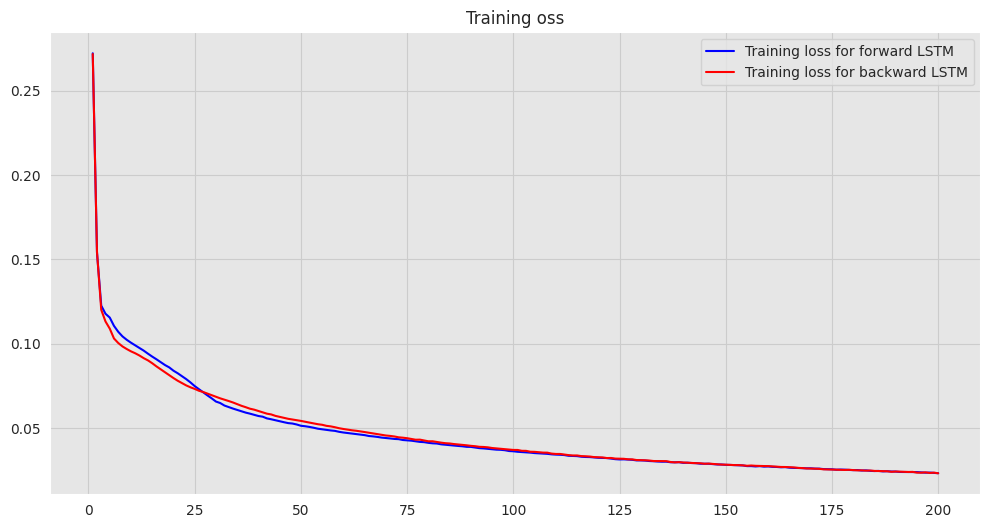

In [ ]:
r1_loss = r1.history['loss']
r2_loss = r2.history['loss']

epochs = range(1, len(r1_loss) + 1)

plt.figure()

plt.plot(epochs, r1_loss, 'b', label='Training loss for forward LSTM')
plt.plot(epochs, r2_loss, 'r', label='Training loss for backward LSTM')
plt.title('Training oss')
plt.legend()

plt.show()

In [ ]:
y_for = lstm_for.predict(X_for)

8/8 [==============================] - 2s 27ms/step


In [ ]:
y_back = lstm_back.predict(X_back)

8/8 [==============================] - 1s 26ms/step


In [ ]:
y_for = np.round(y_for)
y_back = np.round(y_back)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_true=Y, y_pred=y_for), mean_squared_error(y_true=Y, y_pred=y_back)

(0.023448823, 0.023454754)

In [ ]:
lstm_for.save('/content/drive/MyDrive/lstm_for_casia.h5')

In [ ]:
lstm_back.save('/content/drive/MyDrive/lstm_back_casia.h5')